In [20]:
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt

## Gaia Nearby Stars: First Exploration

Goal:
Query Gaia DR3 for nearby stars and construct a basic
Color–Magnitude Diagram to identify stellar populations.

In [21]:
query = """
SELECT TOP 1000
    source_id,
    ra,
    dec,
    parallax,
    parallax_error,
    phot_g_mean_mag,
    bp_rp
FROM gaiadr3.gaia_source
WHERE parallax > 5
"""
job = Gaia.launch_job(query)
results = job.get_results()

len(results)

1000

In [22]:
results.colnames
results[:5]

source_id,ra,dec,parallax,parallax_error,phot_g_mean_mag,bp_rp
,deg,deg,mas,mas,mag,mag
int64,float64,float64,float64,float32,float32,float32
16011638278912,45.21060162891327,0.35420090415756467,6.074725869812678,0.08343153,16.829012,2.6027002
31958852451968,44.855783116029166,0.42114416545036587,8.719777712193455,0.09841132,15.489061,2.898878
34291019368960,44.96972551433584,0.5245815505991817,7.83652235634592,0.32149395,19.160978,3.378357
40063455536512,45.24883043365541,0.4242656878346362,7.779464887289553,0.72081935,20.024767,2.6931953
98857263018112,44.65528323410468,0.7295742309510806,5.018107165989746,0.063662276,16.734749,2.3810492


In [23]:
# basic finite-value mask
mask = (
    np.isfinite(results['parallax']) &
    np.isfinite(results['phot_g_mean_mag']) &
    np.isfinite(results['bp_rp'])
)

clean = results[mask]

# parallax signal-to-noise cut
snr_mask = clean['parallax'] / clean['parallax_error'] > 10
clean = clean[snr_mask]

len(clean)
print(f"Final sample size: {len(clean)} stars")

Final sample size: 871 stars


In [24]:
parallax = clean['parallax']  # mas
distance_pc = 1000 / parallax

G = clean['phot_g_mean_mag']
abs_G = G - 5 * np.log10(distance_pc) + 5

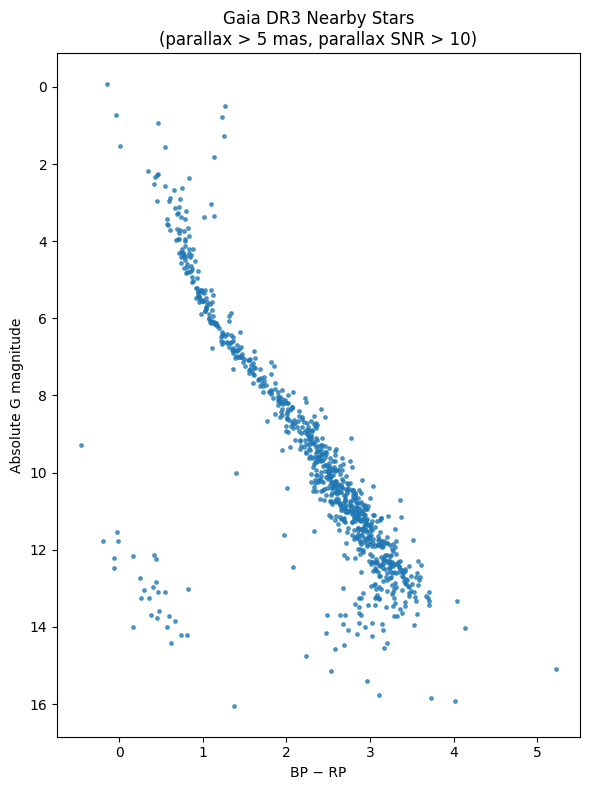

In [25]:
plt.figure(figsize=(6,8))
plt.scatter(clean['bp_rp'], abs_G, s=6, alpha=0.7)
plt.gca().invert_yaxis()
plt.xlabel('BP − RP')
plt.ylabel('Absolute G magnitude')
plt.title('Gaia DR3 Nearby Stars\n(parallax > 5 mas, parallax SNR > 10)')
plt.tight_layout()
plt.show()